In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取并整理数据

In [2]:
files = ['AMZN.csv', 'GCTAY.csv', 'AMD.csv', 'OPCH.csv', 'TSLA.csv']
data = {}

for (i, f) in enumerate(files):
    df = pd.read_csv(f)
    name = f.split('.')[0]

    # 取日期和收盘价
    data[name] = df.Close
    if i == len(files) - 1:
        data['date'] = df.Date

data_df = pd.DataFrame(data)
data_df['date'] = pd.to_datetime(data_df.date)
data_df.head()

,AMZN,GCTAY,AMD,OPCH,TSLA,date
0,3203.080078,6.42,77.169998,18.709999,580.880005,2021-05-21
1,3244.989990,6.33,77.440002,18.860001,606.440002,2021-05-24
2,3259.050049,6.45,77.860001,18.690001,604.690002,2021-05-25
3,3265.159912,6.51,78.339996,19.200001,619.130005,2021-05-26
4,3230.110107,6.45,78.419998,19.020000,630.849976,2021-05-27


In [3]:
datax = data_df.drop('date', axis=1)
r = datax.pct_change().mean() * 252
cov = datax.pct_change().cov() * 252

In [4]:
r

AMZN    -0.324283
GCTAY   -0.457469
AMD      0.338345
OPCH     0.519911
TSLA     0.299608
dtype: float64

In [5]:
cov = cov.values  # 转化为矩阵格式
cov

array([[0.1454329 , 0.03287028, 0.10930189, 0.04944198, 0.09615434],
       [0.03287028, 0.30852696, 0.08867069, 0.03508676, 0.06199972],
       [0.10930189, 0.08867069, 0.29429898, 0.06611684, 0.1747025 ],
       [0.04944198, 0.03508676, 0.06611684, 0.17298303, 0.06949885],
       [0.09615434, 0.06199972, 0.1747025 , 0.06949885, 0.33192047]])

# 随机权重产生投资组合，构造可行集

In [6]:
def weights(n):
    """
    随机产生资产组合的权重向量w
    """
    w = np.random.normal(0, 1, n)
    return w / w.sum()


def performance(R=r, Cov=cov, w=np.zeros(5)):
    """
    给定各资产的收益率（向量R）、协方差矩阵（Cov）和资产组合权重（向量w），
    返回portfolio的平均收益率、标准差和夏普比率
    """
    rf = 0.04  # 无风险收益率
    
    p_mean = np.sum(r * w)  # rp = w'r
    
    p_var = np.dot(w.T, Cov.dot(w))  # Varp = w'Σ w
    p_std = np.sqrt(p_var)
    
    p_sharpe = (p_mean-rf) / p_std  # portfolio的夏普比率
    
    return p_mean, p_std, p_sharpe

In [7]:
np.random.seed(1)
p_mean, p_std, p_sharpe = np.column_stack([performance(w=weights(5)) for _ in range(20000)]) # 产生随机组合

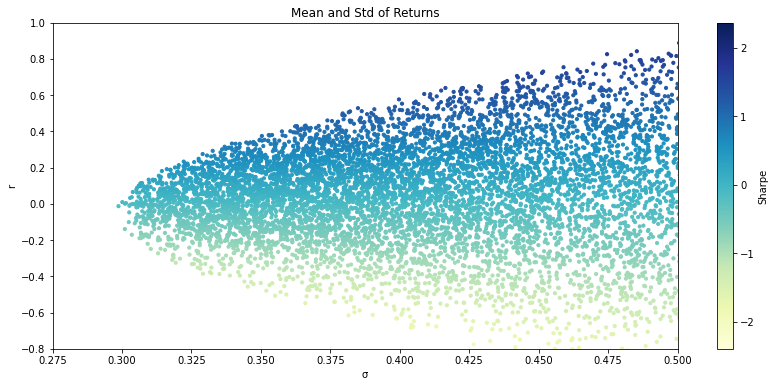

In [8]:
plt.figure(figsize=(14, 6))

# 画出可行集
plt.scatter(p_std, p_mean, c=p_sharpe, marker='o', cmap='YlGnBu', s=10)

plt.xlim([0.275, 0.5])
plt.ylim([-0.8, 1])
plt.xlabel('σ')
plt.ylabel('r')
plt.colorbar(label='Sharpe')
plt.title('Mean and Std of Returns')
plt.show()

# 用Markowitz模型的解计算最小方差组合

In [9]:
# r: 向量，各资产的收益率
# cov: 协方差矩阵
n = 5
e = np.ones(n)
cov_inv = np.linalg.inv(cov)

Crr = np.dot(r.T, cov_inv.dot(r))
Cer = np.dot(e.T, cov_inv.dot(r))
Cee = np.dot(e.T, cov_inv.dot(e))

In [10]:
least_varp = 1 / Cee
least_std = np.sqrt(least_varp)
least_rd = Cer / Cee

print(f"最小方差组合，标准差为{least_std}，组合收益率为{least_rd}")

最小方差组合，标准差为0.2982303301986362，组合收益率为-0.05291879954498379


# 用Markowitz模型的解计算有效前沿

In [11]:
r_min = least_rd  # 从r = r*开始取
r_mean_list = np.linspace(r_min, r_min+6.5, 650)

In [12]:
dominator = Crr * Cee - Cer**2
std_list_MM = []

for rd in r_mean_list:
    best_var_MM = (Cee * rd**2 - 2 * Cer * rd + Crr) / dominator
    std_list_MM.append(np.sqrt(best_var_MM))

# 画出可行集和有效前沿

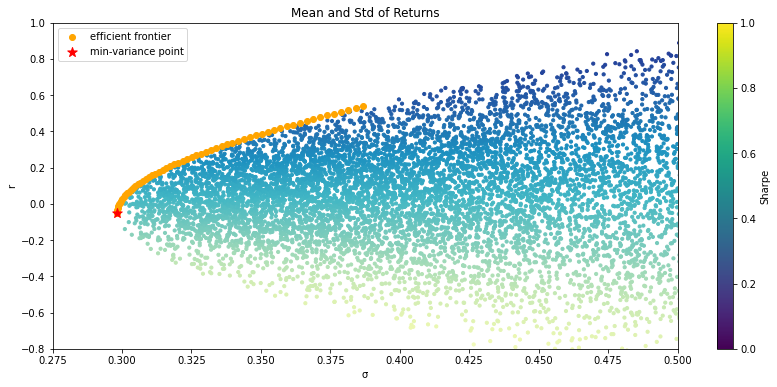

In [13]:
plt.figure(figsize=(14, 6))

# 画出可行集
plt.scatter(p_std, p_mean, c=p_sharpe, marker='o', cmap='YlGnBu', s=10)

# 标记有效前沿
plt.scatter(std_list_MM[:60], r_mean_list[:60], marker='o', color='orange', label='efficient frontier')

# 标记最小方差组合
plt.scatter(least_std, least_rd, c='r', marker='*', s=100, label='min-variance point')

plt.xlim([0.275, 0.5])
plt.ylim([-0.8, 1])
plt.xlabel('σ')
plt.ylabel('r')
plt.colorbar(label='Sharpe')
plt.legend()
plt.title('Mean and Std of Returns')
plt.show()

# 引入无风险资产

In [14]:
rf = 0.04

In [15]:
# 计算切点
r_tangen = (Crr - rf * Cer) / (Cer - rf * Cee)
var_tangen = (r_tangen - rf) / (Cer - rf * Cee)
# 等价的：var_tangen = (Crr - 2 * rf * Cer + rf**2 * Cee) / (Cer - rf * Cee)**2
std_tangen = np.sqrt(var_tangen)

if r_tangen < least_rd:
    r_tangen = -1 * r_tangen

print(f"切点投资组合，收益率为{r_tangen}，标准差为{std_tangen}")

切点投资组合，收益率为5.562927990885715，标准差为2.315834580740373


## 画出MM2的有效前沿

In [16]:
# 用解析式计算有效前沿
def eff_front_MM2(rd):
    dom = Crr - 2 * rf * Cer + rf * rf * Cee
    lam = (rd - rf) / dom
    w = lam * cov_inv.dot(r - rf * e)
    var = np.dot(w.T, cov.dot(w))
    return np.sqrt(var)


r_list2 = np.linspace(r_min+0.5, r_min+7, 10)
sig_list2 = []
for rd in r_list2:
    sig = eff_front_MM2(rd)
    sig_list2.append(sig)

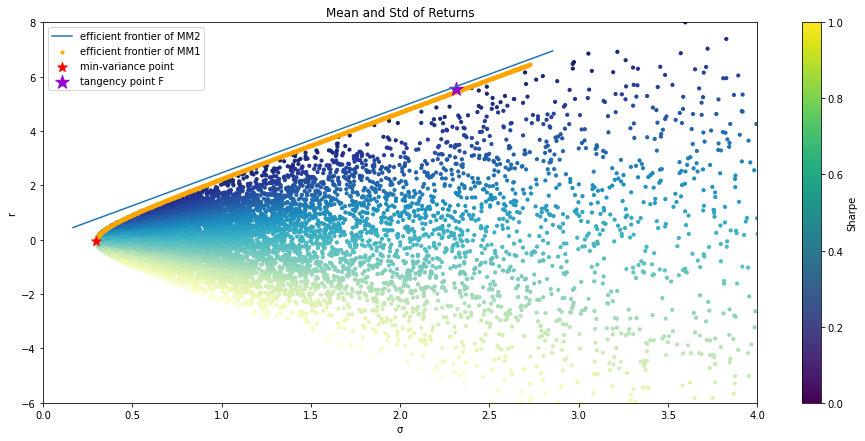

In [19]:
plt.figure(figsize=(16, 7))

# 画出可行集
plt.scatter(p_std, p_mean, c=p_sharpe, marker='o', cmap='YlGnBu', s=10)

# 标记有效前沿
plt.scatter(std_list_MM, r_mean_list, marker='o', color='orange', s=10, label='efficient frontier of MM1')

# 标记最小方差组合
plt.scatter(least_std, least_rd, c='r', marker='*', s=100, label='min-variance point')

# 标记切点组合
plt.scatter(std_tangen, r_tangen, c='darkviolet', marker='*', s=200, label='tangency point F')

# 画出MM2的有效前沿
plt.plot(sig_list2, r_list2, label='efficient frontier of MM2')

plt.xlim([0, 4])
plt.ylim([-6, 8])
plt.xlabel('σ')
plt.ylabel('r')
plt.colorbar(label='Sharpe')
plt.legend()
plt.title('Mean and Std of Returns')
plt.show()